<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from otherproject import transform
%load_ext autoreload
%autoreload 2

import os
import socket

cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

Host: deeplearning-vm
You are here: /home/sebelino7_gmail_com/pycharm_depl


In [2]:
from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Training results should now be reproducible.


# Train model

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.0055905797197103695,
    "weight_decay": 9.123321505007701e-06,
    "momentum": 0.791610254744395,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "augmentation": {
    "enabled": false,
    "transform": "Compose(\n    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)\n    RandomHorizontalFlip(p=0.5)\n    ToTensor()\n    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])\n)"
  },
  "unsup_weight": 0.5,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}
Training result:
{
  "training_losses": [2.7042553578653643, 0.8667288332857112, 0.343195304274559, 0.2172355871367198, 0.1410472479959329, 0.09834357429175608, 0.08038440587059144, 0.05191137367278658, 0.05467883329237661, 0.06239093201214908],
  "training_acc

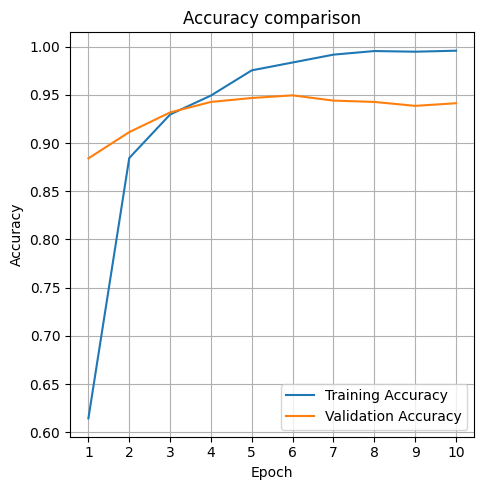

In [59]:
from typing import Literal
import augmentation
from augmentation import AugmentationParams
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    #class_fractions=(0.2,)*37,
    class_fractions=(1.0,) * 37,
    validation_set_fraction=0.2,  # 20 % of trainval set
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.0055905797197103695,
        weight_decay=9.123321505007701e-06,
        momentum=0.791610254744395,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    augmentation=AugmentationParams(
        enabled=False,
        transform=augmentation.to_transform(architecture, ["resize", "flip"])
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)


In [ ]:
# Second plot: Rerun training multiple times with different seed
run_with_different_seeds(dataset_params, baseline_params, trials=2)

Running trial 1/1 for augmentation.enabled=True,optimizer.learning_rate=0.0055905797197103695,optimizer.momentum=0.791610254744395
Running trial 1/1 for augmentation.enabled=True,optimizer.momentum=0.9
Running trial 1/1 for augmentation.enabled=True,optimizer.learning_rate=0.005


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.7793, Train Acc: 60.96%, Val Acc: 88.96%
Epoch [2/10], Loss: 0.9448, Train Acc: 87.81%, Val Acc: 91.83%
Epoch [3/10], Loss: 0.3660, Train Acc: 92.50%, Val Acc: 92.78%
Epoch [4/10], Loss: 0.2444, Train Acc: 94.23%, Val Acc: 93.87%
Epoch [5/10], Loss: 0.1791, Train Acc: 95.96%, Val Acc: 94.69%
Epoch [6/10], Loss: 0.1343, Train Acc: 97.15%, Val Acc: 94.82%
Epoch [7/10], Loss: 0.1164, Train Acc: 97.90%, Val Acc: 94.96%
Epoch [8/10], Loss: 0.0859, Train Acc: 98.27%, Val Acc: 94.41%
Epoch [9/10], Loss: 0.0819, Train Acc: 98.57%, Val Acc: 94.82%
Epoch [10/10], Loss: 0.0807, Train Acc: 99.19%, Val Acc: 94.96%
Total elapsed: 114.00s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/037527fc3cd9aa188297fd1d6bf8013f.pth
Final mean val acc: 94.69 % for augmentation.enabled=True,optimizer.learning_rate…
Final mean val acc: 93.87 % for augmentation.enabled=True,optimizer.momentum=0.9
Final mean val acc: 94.96 % for augmentation.enabled=True,optimize

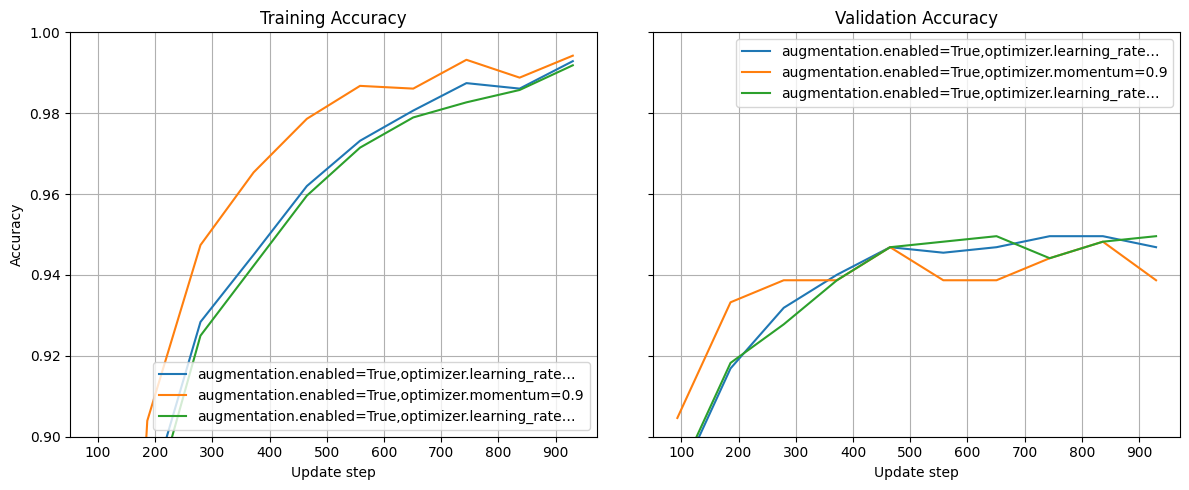

In [61]:
from evaluation import override_param_sets, evaluate_runs_ci, evaluate_runs_print
from run import run_multiple

overrides = [
    #dict(augmentation=dict(enabled=True, transform=augmentation.to_transform(architecture, ["resize"])), n_epochs=10),
    #dict(augmentation=dict(enabled=True, transform=augmentation.to_transform(architecture, ["resize", "flip", "rotate"])), n_epochs=10),
    #dict(augmentation=dict(enabled=True, transform=augmentation.to_transform(architecture, ["resize", "flip", "colorjitter"])), n_epochs=10),

    dict(augmentation=dict(enabled=True), optimizer=dict(learning_rate=0.0055905797197103695,momentum=0.791610254744395)),
    dict(augmentation=dict(enabled=True), optimizer=dict(momentum=0.9)),
    dict(augmentation=dict(enabled=True), optimizer=dict(learning_rate=0.005)),
]
param_sets = override_param_sets(baseline_params, overrides)
results = run_multiple(dataset_params, param_sets, determinism, invalidate=False, trials=1)
evaluate_runs_print(results)
evaluate_runs_ci(results)


# Test model

In [62]:

from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning

suppress_weights_only_warning()

training_params = baseline_params

training_params.augmentation.enabled = True
training_params.n_epochs = 10
training_params.optimizer.learning_rate = 0.005

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(training_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/037527fc3cd9aa188297fd1d6bf8013f.pth (epoch 10)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 92.70%


# Misclassified images

In [ ]:
from evaluation import show_misclassified

final_test_acc, misclassified_samples = evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_samples)}")
show_misclassified(misclassified_samples)